# Small data and deep learning
This mini-project proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should not exceed 2MB. Please name your notebook (LASTNAME)\_(FIRSTNAME).ipynb, zip/tar it with any necessary files required to run your notebook, in a compressed file named (LASTNAME)\_(FIRSTNAME).X where X is the corresponding extension. Zip/tar files exceeding 2MB will not be considered for grading. Submit the compressed file via the submission link provided on the website of the class.__

You can use https://colab.research.google.com/ to run your experiments.

## Imports

In [0]:
!pip uninstall scikit-cuda
!rm -r scikit_cuda
!rm -r scikit-cuda
!git clone https://github.com/lebedov/scikit-cuda.git
!mv scikit-cuda scikit_cuda
%cd scikit_cuda
!python setup.py install
from scikit_cuda.skcuda import cublas, cufft

Skipping scikit-cuda as it is not installed.
Cloning into 'scikit-cuda'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 5708 (delta 12), reused 16 (delta 6), pack-reused 5678
Receiving objects: 100% (5708/5708), 2.40 MiB | 21.05 MiB/s, done.
Resolving deltas: 100% (3404/3404), done.


In [0]:
!git clone https://github.com/edouardoyallon/pyscatwave.git
from pyscatwave.scatwave.scattering import Scattering

In [0]:
from PIL import Image
import os
import time
import copy
import os.path
import numpy as np
import math
from collections import OrderedDict
import sys
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
from torchvision.models.resnet import *
from torchvision.models.vgg import *
from sklearn import svm

device = "cpu"

In [0]:
from google.colab import drive
drive.mount('/content/drive')
PATH = "drive/My Drive/Colab Notebooks/discriminator.pt"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Disclaimer

* It may be that the results I give in the table are a little different with the cell outputs. This is because the output changes when I change the hyperparameters, and the results obtained are worse than the previous ones, and when I change the model (for example, Resnet 18 and 50), the results of the previous model are lost.
* I could not send the pre-trained discriminator for the "DCGan features" question, because its size is very large (40 MB), but the link for the downloaded one is as follows: https://github.com/donand/GAN_pytorch/blob/master/DCGAN/results_celeba/checkpoint_ep10/discriminator.pt

## Training set creation
__Question 1:__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

__Answer__: To obtain a dataloader with only 100 samples, we simply take only 100 samples in the attributes `self.data` of the CIFAR10 class, after shuffling both the data and the labels.

In [0]:
testset = torchvision.datasets.CIFAR10(root='./root', train=True,
                                       download=True)
p = np.random.permutation(len(testset.data))
testset.data = testset.data[p][:100,:,:,:]
testset.targets = np.array(testset.targets)[p][:100]

Files already downloaded and verified


This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2:__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

__Answer__: The problems that can be encountered are that when using a small dataset, the network can easily overfit and therefore will not have a great power of generalization. To remedy this, we can show the network different images during training using data augumentation, use transfer learning, and in this case, we won't need many images to train the network, and finally, we can use weak supervision, to benefit from our unlabeled part of the dataset.


# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performances with reported number from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context, as those researchers had access to GPUs.

## ResNet architectures

__Question 3:__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1409.1556 ). If possible, please report the accuracy obtained on the whole dataset, as well as the reference paper/GitHub link you might have used.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (~5 minutes).

__Answer__: I tried resnet18 and resnet50 by resing the code provided. I also used data augumentation (random crop, random flip), and learning rate decay (i've done this manually) as regularizers for the network. After cross validation, I find:

| Model | Number of  epochs  | Train accuracy | Test accuracy | Accuracy on all the dataset | source
|------|------|------|------|------|------|
|   Resnet18  | 60 | 83 % | 27 %|93.02 % | https://github.com/kuangliu/pytorch-cifar|
|   Resnet50  | 60 | 22 % | 14 %|93.62 % | https://github.com/kuangliu/pytorch-cifar|

In [0]:
# hyperparameters
lr = 0.01
batch_size = 10

# Data augumentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Load train
trainset = torchvision.datasets.CIFAR10(root='./root', train=True, download=True, transform=transform_train)
# Keep 100 examples
p = np.random.permutation(len(trainset.data))
trainset.data = trainset.data[p][:100,:,:,:]
trainset.targets = np.array(trainset.targets)[p][:100]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Load test
testset = torchvision.datasets.CIFAR10(root='./root', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


# Load architecture: Resnet 18 / 50
net = resnet50()
net = net.to(device)


# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# Train network
def train(epoch):
  
    print('\n===Train===\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print( 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(epoch):
    print('\n===Test===\nEpoch: %d' % epoch)
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

start_epoch = 0
epochs = 30
for epoch in range(start_epoch, start_epoch+epochs):
    train(epoch)
    test(epoch)

Files already downloaded and verified
Files already downloaded and verified

===Train===
Epoch: 0
Loss: 7.160 | Acc: 0.000% (0/10)
Loss: 5.916 | Acc: 5.000% (1/20)
Loss: 5.732 | Acc: 10.000% (3/30)
Loss: 5.327 | Acc: 10.000% (4/40)
Loss: 6.158 | Acc: 10.000% (5/50)
Loss: 7.854 | Acc: 10.000% (6/60)
Loss: 8.463 | Acc: 8.571% (6/70)
Loss: 8.969 | Acc: 8.750% (7/80)
Loss: 8.976 | Acc: 10.000% (9/90)
Loss: 8.962 | Acc: 10.000% (10/100)

===Test===
Epoch: 0
Loss: 7333762.500 | Acc: 11.000% (11/100)
Loss: 7701061.500 | Acc: 10.500% (21/200)
Loss: 7546623.000 | Acc: 11.667% (35/300)
Loss: 7555053.750 | Acc: 11.250% (45/400)
Loss: 7508350.300 | Acc: 11.200% (56/500)
Loss: 7299439.583 | Acc: 11.833% (71/600)
Loss: 7270857.714 | Acc: 11.857% (83/700)
Loss: 7273020.188 | Acc: 11.500% (92/800)
Loss: 7341365.778 | Acc: 10.778% (97/900)
Loss: 7272753.000 | Acc: 10.900% (109/1000)
Loss: 7270631.273 | Acc: 10.455% (115/1100)
Loss: 7322141.708 | Acc: 10.333% (124/1200)
Loss: 7371650.346 | Acc: 10.462% 

In [0]:
lr = 0.00001
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
start_epoch = 50
epochs = 20
for epoch in range(start_epoch, start_epoch+epochs):
    train(epoch)
    test(epoch)


===Train===
Epoch: 50
Loss: 2.528 | Acc: 30.000% (3/10)
Loss: 2.500 | Acc: 25.000% (5/20)
Loss: 2.737 | Acc: 16.667% (5/30)
Loss: 2.539 | Acc: 22.500% (9/40)
Loss: 2.499 | Acc: 26.000% (13/50)
Loss: 2.406 | Acc: 23.333% (14/60)
Loss: 2.330 | Acc: 25.714% (18/70)
Loss: 2.289 | Acc: 26.250% (21/80)
Loss: 2.305 | Acc: 26.667% (24/90)
Loss: 2.317 | Acc: 24.000% (24/100)

===Test===
Epoch: 50
Loss: 9.139 | Acc: 10.000% (10/100)
Loss: 10.863 | Acc: 9.500% (19/200)
Loss: 8.570 | Acc: 11.333% (34/300)
Loss: 8.303 | Acc: 11.250% (45/400)
Loss: 7.425 | Acc: 12.200% (61/500)
Loss: 7.386 | Acc: 12.833% (77/600)
Loss: 6.930 | Acc: 13.429% (94/700)
Loss: 6.896 | Acc: 13.250% (106/800)
Loss: 6.768 | Acc: 13.556% (122/900)
Loss: 6.631 | Acc: 13.200% (132/1000)
Loss: 6.593 | Acc: 12.636% (139/1100)
Loss: 6.379 | Acc: 12.583% (151/1200)
Loss: 6.514 | Acc: 12.385% (161/1300)
Loss: 6.694 | Acc: 12.786% (179/1400)
Loss: 6.870 | Acc: 12.867% (193/1500)
Loss: 6.607 | Acc: 13.375% (214/1600)
Loss: 6.482 | Ac

## VGG-like architectures

__Question 4:__ Same question as before, but with a *VGG*. Which model do you recommend?


__Answer__: Using the same method as before, and using a cross validation to find the best hyperparameters, we find:

| Model | Number of  epochs  | Train accuracy | Test accuracy | Accuracy on all the dataset | source
|------|------|------|------|------|------|
|   VGG16  | 90 | 13 % | 10 %|	92.64%| https://github.com/kuangliu/pytorch-cifar|
|   VGG19  | 100 | 16 % | 10 %|91.52 % |https://www.researchgate.net/publication/324584468_MaxGain_Regularisation_of_Neural_Networks_by_Constraining_Activation_Magnitudes/figures?lo=1|
|   VGG11_bn  | 90 | 19 % | 16 %|	| |

we can see that resnet gives a better result than VGG. This result is not surprising in the case of a full dataset, but it is apparently true in the case of small data.

In [0]:
# hyperparameters
lr = 0.1
batch_size = 32

# Load train
trainset = torchvision.datasets.CIFAR10(root='./root', train=True, download=True, transform=transform_train)
# Keep 100 examples
p = np.random.permutation(len(trainset.data))
trainset.data = trainset.data[p][:100,:,:,:]
trainset.targets = np.array(trainset.targets)[p][:100]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Load test
testset = torchvision.datasets.CIFAR10(root='./root', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load architecture: vgg11/16/19
net = vgg11_bn()
net = net.to(device)

# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=lr)

start_epoch = 0
epochs = 50
for epoch in range(start_epoch, start_epoch+epochs):
    train(epoch)
    test(epoch)

Files already downloaded and verified
Files already downloaded and verified

===Train===
Epoch: 0
Loss: 5122885.980 | Acc: 7.000% (7/100)

===Test===
Epoch: 0
Loss: 3310953146.880 | Acc: 10.000% (1000/10000)

===Train===
Epoch: 1
Loss: 14995.516 | Acc: 13.000% (13/100)

===Test===
Epoch: 1
Loss: 88118913.680 | Acc: 10.000% (1000/10000)

===Train===
Epoch: 2
Loss: 15531.241 | Acc: 15.000% (15/100)

===Test===
Epoch: 2
Loss: 47984592.520 | Acc: 9.470% (947/10000)

===Train===
Epoch: 3
Loss: 16392.266 | Acc: 10.000% (10/100)

===Test===
Epoch: 3
Loss: 21947372.660 | Acc: 10.010% (1001/10000)

===Train===
Epoch: 4
Loss: 30377.628 | Acc: 11.000% (11/100)

===Test===
Epoch: 4
Loss: 4269852.875 | Acc: 12.380% (1238/10000)

===Train===
Epoch: 5
Loss: 24455.188 | Acc: 11.000% (11/100)

===Test===
Epoch: 5
Loss: 851519.432 | Acc: 8.880% (888/10000)

===Train===
Epoch: 6
Loss: 14823.695 | Acc: 8.000% (8/100)

===Test===
Epoch: 6
Loss: 1084117.577 | Acc: 16.830% (1683/10000)

===Train===
Epoch: 7


In [0]:
lr = 0.0001
optimizer = optim.Adam(net.parameters(), lr=lr)
start_epoch = 50
epochs = 20
for epoch in range(start_epoch, start_epoch+epochs):
    train(epoch)
    test(epoch)


===Train===
Epoch: 50
Loss: 2.292 | Acc: 12.000% (12/100)

===Test===
Epoch: 50
Loss: 2609.190 | Acc: 12.440% (1244/10000)

===Train===
Epoch: 51
Loss: 2.241 | Acc: 16.000% (16/100)

===Test===
Epoch: 51
Loss: 2071.229 | Acc: 12.350% (1235/10000)

===Train===
Epoch: 52
Loss: 2.348 | Acc: 10.000% (10/100)

===Test===
Epoch: 52
Loss: 1288.794 | Acc: 12.070% (1207/10000)

===Train===
Epoch: 53
Loss: 2.343 | Acc: 12.000% (12/100)

===Test===
Epoch: 53
Loss: 1136.236 | Acc: 12.040% (1204/10000)

===Train===
Epoch: 54
Loss: 2.218 | Acc: 18.000% (18/100)

===Test===
Epoch: 54
Loss: 2062.610 | Acc: 12.380% (1238/10000)

===Train===
Epoch: 55
Loss: 2.308 | Acc: 9.000% (9/100)

===Test===
Epoch: 55
Loss: 1014.241 | Acc: 11.910% (1191/10000)

===Train===
Epoch: 56
Loss: 2.391 | Acc: 9.000% (9/100)

===Test===
Epoch: 56
Loss: 819.034 | Acc: 11.790% (1179/10000)

===Train===
Epoch: 57
Loss: 2.316 | Acc: 12.000% (12/100)

===Test===
Epoch: 57
Loss: 889.049 | Acc: 11.810% (1181/10000)

===Train===
E

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 5:__ Pick a model from the list above, adapt it to CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.


__Answer__: I adapted the code provided in here: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html. I used DensNet architecture pretrained on ImageNet, and i trained the whole network (and not only same layers). The obtained results are the following:

| Model | Number of  epochs  | Train accuracy | Test accuracy | Accuracy on all the dataset | source
|------|------|------|------|------|------|
|   DenseNet  | 60 | 97 % | 37 %|	95.04%| https://github.com/kuangliu/pytorch-cifar|

In [0]:
# Hyperparameters
batch_size = 8
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
# Number of epochs to train for
num_epochs = 60

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

dataloaders = {'train': trainloader, 'val':testloader}

# Train hole model or just some layers
feature_extract = False
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

## Define model
model_ft = models.densenet121(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)

Params to learn:
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.de

## DCGan features

GANs correspond to an unsupervised technique for generating images. In https://arxiv.org/pdf/1511.06434.pdf, Sec. 5.1 shows that the representation obtained from the Discriminator has some nice generalization properties on CIFAR10.

__Question 6:__  Using for instance a pretrained model from https://github.com/soumith/dcgan.torch combined with https://github.com/pytorch/examples/tree/master/dcgan, propose a model to train on $\mathcal{X}_{\text{train}}$. Train it and report its accuracy.

*Hint:* You can use the library: https://github.com/bshillingford/python-torchfile to load the weights of a model from torch(Lua) to pytorch(python).

__Answer__: I used the architecture of the descriminator provided in the DCGAN paper (https://github.com/pytorch/examples/blob/master/dcgan/main.py#L182) and the pretrained weights of this github repo (https://github.com/donand/GAN_pytorch) trained on celebA (I didnt't find any repo with pretrained discriminator on ImageNet). I followed the same feature extraction method combined with a SVM classifier as described in Sec. 5.1. I obtaied an accuracy = **28.38 %** (after a cross validation for hyperparameters tunning). I think this score can be improved as the weights for the descriminator are not perfect (the used network is trained for 10 epochs only).

In [0]:
# Define model

image_size = (1, 64, 64)
class Discriminator(nn.Module):
    def __init__(self, input_channels=3, nf=128):
        super(Discriminator, self).__init__()
        self.flattened_size = 64 * \
            (image_size[1]//2//2//2) * (image_size[2]//2//2//2)
        self.conv_block = nn.Sequential(
            # input is (3, 32, 32)
            nn.Conv2d(input_channels, nf, 4, padding=1, stride=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # input is (nf, 16, 16)
            nn.Conv2d(nf, nf * 2, 4, padding=1, stride=2),
            nn.BatchNorm2d(nf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # input is (nf*2, 8, 8)
            nn.Conv2d(nf * 2, nf * 4, 4, padding=1, stride=2),
            nn.BatchNorm2d(nf * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(nf * 4, nf * 8, 4, padding=1, stride=2),
            nn.BatchNorm2d(nf * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            # input is (nf*4, 4, 4)
            nn.Conv2d(nf * 8, 1, 4, padding=0, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_block(x)
        return x.view(-1, 1)
    
    def get_features(self, input):
      
        self.conv1 = nn.Sequential(
            self.conv_block._modules['0'],
            self.conv_block._modules['1'],
        )
        self.conv2 = nn.Sequential(
              self.conv_block._modules['2'],
              self.conv_block._modules['3'],
              self.conv_block._modules['4'],
          )
        self.conv3 = nn.Sequential(
              self.conv_block._modules['5'],
              self.conv_block._modules['6'],
              self.conv_block._modules['7'],
          )
        self.conv4 = nn.Sequential(
              self.conv_block._modules['8'],
              self.conv_block._modules['9'],
              self.conv_block._modules['10'],
          )
        self.conv5 = nn.Sequential(
              self.conv_block._modules['11'],
              self.conv_block._modules['12']
          )
      
      
        out_conv1 = self.conv1(input)
        out_conv2 = self.conv2(out_conv1)
        out_conv3 = self.conv3(out_conv2)
        out_conv4 = self.conv4(out_conv3)
        out_conv5 = self.conv5(out_conv4)

        max_pool1 = nn.MaxPool2d(int(out_conv1.size(2) / 4))
        max_pool2 = nn.MaxPool2d(int(out_conv2.size(2) / 4))
        max_pool3 = nn.MaxPool2d(int(out_conv3.size(2) / 4))
        # max_pool4 = nn.MaxPool2d(int(out_conv4.size(2) / 4))

        vector1 = max_pool1(out_conv1).view(input.size(0), -1).squeeze(1)
        vector2 = max_pool2(out_conv2).view(input.size(0), -1).squeeze(1)
        vector3 = max_pool3(out_conv3).view(input.size(0), -1).squeeze(1)
        # vector4 = max_pool4(out_conv4).view(input.size(0), -1).squeeze(1)

        return torch.cat((vector1, vector2, vector3), 1)

# Load model
netD = Discriminator().to(device)
netD.load_state_dict(torch.load(PATH))

# Load train
transform = transforms.Compose([
                               transforms.Resize(64),
                               transforms.CenterCrop(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ])
trainset = torchvision.datasets.CIFAR10(root='./root', train=True, download=True, transform=transform)
# Keep 100 examples
p = np.random.permutation(len(trainset.data))
trainset.data = trainset.data[p][:100,:,:,:]
trainset.targets = np.array(trainset.targets)[p][:100]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

# Load test
testset = torchvision.datasets.CIFAR10(root='./root', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Extract Features
input = torch.FloatTensor(100, 3, 64, 64).cuda()
features = np.array([])
labels = np.array([])

for i, data in enumerate(trainloader):
    imgs, label = data
    imgs = imgs.cuda()
    input.resize_as_(imgs).copy_(imgs)
    input_v = Variable(input)

    feature = netD.get_features(input_v)
    feature = feature.data.cpu().numpy()
    feature = feature.astype(np.float16)
    if features.size == 0:
        features = feature
        labels = label
    else:
        features = np.concatenate((features, feature), axis=0)
        labels = np.concatenate((labels, label), axis=0)
        
# Extract test features
tfeatures = np.array([])
tlabels = np.array([])
for i, data in enumerate(testloader):
    imgs, label = data
    imgs = imgs.cuda()
    input.resize_as_(imgs).copy_(imgs)
    input_v = Variable(input)

    feature = netD.get_features(input_v)
    feature = feature.data.cpu().numpy()
    feature = feature.astype(np.float16)
    if tfeatures.size == 0:
        tfeatures = feature
        tlabels = label
    else:
        tfeatures = np.concatenate((tfeatures, feature), axis=0)
        tlabels = np.concatenate((tlabels, label), axis=0)
        
print("Size of test")
print('number of samples ', tlabels.shape)
print(tfeatures.shape)

# Training
print("Size of training")
print('number of samples ', labels.shape)
print(features.shape)

clf = svm.SVC(C=8, decision_function_shape='ovo', gamma='scale')
clf.fit(features, labels)

# Predict
print('predict svm')
val_labels = tlabels.squeeze()
predicted_labels = clf.predict(tfeatures)
print(len(val_labels), len(predicted_labels))
a = predicted_labels == val_labels
print(np.sum(a))
accuracy = np.sum(predicted_labels == val_labels) / len(val_labels)

print('svm results: {} % accuracy'.format(accuracy*100))

Files already downloaded and verified
Files already downloaded and verified
Size of test
number of samples  (10000,)
(10000, 14336)
Size of training
number of samples  torch.Size([100])
(100, 14336)
predict svm
10000 10000
2838
svm results: 28.38 % accuracy


# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 7:__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

__Answer__: The problem with small resolution images is that the transformation may destroy the features that classify the image and make it difficult to classify even for a human. For example, scaling with a large factor can zoom in the middle of the image, and since we are dealing with a low resolution image, the middle pixels are not representative of the class. To remedy this, the transformations must be performed by limiting their effect, for example, if it is a translation, a very small translation step must be used.

## Data augmentations

__Question 8:__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ and __Question 4__ with them and report the accuracies.

__Answer__: Some transformations that could be used are: Rotation, RandomCrop, ColorJitter and RandomGrayScale. After training the models from Question 3 and 4 using this transforms and tunning the huperparameters, we find:


| Model | Number of  epochs  | Train accuracy | Test accuracy | Accuracy on all the dataset | source
|------|------|------|------|------|------|
|   Resnet18  | 60 | 82 % | 27 %|93.02 % | https://github.com/kuangliu/pytorch-cifar|
|   Resnet50  | 70 | 95 % | 19 %|93.62 % | https://github.com/kuangliu/pytorch-cifar|
|   VGG16  | 90 | 32 % | 15 %|	92.64%| https://github.com/kuangliu/pytorch-cifar|
|   VGG19  | 100 | 16 % | 11.6 %|91.52 % | https://www.researchgate.net/publication/324584468_MaxGain_Regularisation_of_Neural_Networks_by_Constraining_Activation_Magnitudes/figures?lo=1|

We see that in some cases the results are improved, but only with a small percentage compared to the results found in questions 3 and 4.

In [0]:
# hyperparameters
lr = 0.01
batch_size = 64

# Data augumentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(hue=.05, saturation=.05),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Load train
trainset = torchvision.datasets.CIFAR10(root='./root', train=True, download=True, transform=transform_train)
# Keep 100 examples
p = np.random.permutation(len(trainset.data))
trainset.data = trainset.data[p][:100,:,:,:]
trainset.targets = np.array(trainset.targets)[p][:100]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Load test
testset = torchvision.datasets.CIFAR10(root='./root', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


# Load architecture: Resnet / VGG
net = vgg19()
net = net.to(device)


# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# Train network
def train(epoch):
  
    print('\n===Train===\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print( 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(epoch):
    print('\n===Test===\nEpoch: %d' % epoch)
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

start_epoch = 0
epochs = 50
for epoch in range(start_epoch, start_epoch+epochs):
    train(epoch)
    test(epoch)

Files already downloaded and verified
Files already downloaded and verified

===Train===
Epoch: 0
Loss: 6.899 | Acc: 0.000% (0/100)

===Test===
Epoch: 0
Loss: 6.884 | Acc: 9.950% (995/10000)

===Train===
Epoch: 1
Loss: 6.870 | Acc: 3.000% (3/100)

===Test===
Epoch: 1
Loss: 6.834 | Acc: 10.000% (1000/10000)

===Train===
Epoch: 2
Loss: 6.787 | Acc: 15.000% (15/100)

===Test===
Epoch: 2
Loss: 6.676 | Acc: 10.000% (1000/10000)

===Train===
Epoch: 3
Loss: 6.473 | Acc: 14.000% (14/100)

===Test===
Epoch: 3
Loss: 5.084 | Acc: 10.000% (1000/10000)

===Train===
Epoch: 4
Loss: 9.622 | Acc: 19.000% (19/100)

===Test===
Epoch: 4
Loss: 6.699 | Acc: 9.980% (998/10000)

===Train===
Epoch: 5
Loss: 6.790 | Acc: 11.000% (11/100)

===Test===
Epoch: 5
Loss: 6.633 | Acc: 10.000% (1000/10000)

===Train===
Epoch: 6
Loss: 6.770 | Acc: 8.000% (8/100)

===Test===
Epoch: 6
Loss: 6.273 | Acc: 10.000% (1000/10000)

===Train===
Epoch: 7
Loss: 9.717 | Acc: 8.000% (8/100)

===Test===
Epoch: 7
Loss: 6.772 | Acc: 10.00

In [0]:
lr = 0.00001
optimizer = optim.Adam(net.parameters(), lr=lr)
start_epoch = 50
epochs = 30
for epoch in range(start_epoch, start_epoch+epochs):
    train(epoch)
    test(epoch)


===Train===
Epoch: 50
Loss: 2940548956553216.000 | Acc: 18.000% (18/100)

===Test===
Epoch: 50
Loss: 5076202298330317.000 | Acc: 10.410% (1041/10000)

===Train===
Epoch: 51
Loss: 3212624934207488.000 | Acc: 12.000% (12/100)

===Test===
Epoch: 51
Loss: 5051243267610378.000 | Acc: 10.640% (1064/10000)

===Train===
Epoch: 52
Loss: 3640866191179776.000 | Acc: 11.000% (11/100)

===Test===
Epoch: 52
Loss: 4999143938578186.000 | Acc: 10.610% (1061/10000)

===Train===
Epoch: 53
Loss: 3306740955217920.000 | Acc: 11.000% (11/100)

===Test===
Epoch: 53
Loss: 4960697694520607.000 | Acc: 10.700% (1070/10000)

===Train===
Epoch: 54
Loss: 3251283263750144.000 | Acc: 20.000% (20/100)

===Test===
Epoch: 54
Loss: 4953975090912952.000 | Acc: 10.610% (1061/10000)

===Train===
Epoch: 55
Loss: 3469870121353216.000 | Acc: 8.000% (8/100)

===Test===
Epoch: 55
Loss: 4943260845363692.000 | Acc: 10.500% (1050/10000)

===Train===
Epoch: 56
Loss: 3226721956397056.000 | Acc: 14.000% (14/100)

===Test===
Epoch: 56


## Wavelets

__Question 9:__ Use a Scattering Transform as an input to a ResNet-like architecture. You can find a baseline here: https://arxiv.org/pdf/1703.08961.pdf.

*Hint:* You can use the following package: https://www.kymat.io/


__Answer__: In this question, I was inspired by this repo (https://github.com/edouardoyallon/scalingscattering),  I used the same architecture as theirs, and `pyscatwave` for scattering, as I had some problems with Kymatio dependencies. I tried to use the same metodology and hyperparameters (learing rate, decay, batch size, data augumentation, etc) as https://arxiv.org/pdf/1703.08961.pdf in Sec. 4., and I find:

| Model | Number of  epochs  | Train accuracy | Test accuracy | Accuracy in the cited paper | source
|------|------|------|------|------|------|
|   WideResnet  | 70 | 84 % | 30.7 %|38.9 % | https://arxiv.org/pdf/1703.08961|

In [0]:
# define model

def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out




class ResNet(nn.Module):

    def __init__(self, block,J=2,N=32, k=1,n=2,num_classes=10,use_all=False):
        self.inplanes = 16*k
        self.ichannels = 16*k
        super(ResNet, self).__init__()
        self.nspace = N // (2 ** J)
        self.nfscat = int(1 + 8 * J + 8 * 8 * J * (J - 1) / 2)
        self.bn0 = nn.BatchNorm2d(self.nfscat*3,eps=1e-5,affine=False)
        self.conv1 = nn.Conv2d(self.nfscat*3,self.ichannels, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(self.ichannels)
        self.relu = nn.ReLU(inplace=True)
        
            
        self.layer2 = self._make_layer(block, 32*k, n)
        self.layer3 = self._make_layer(block, 64*k, n)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64*k, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                if m.affine:
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
        self.scat = Scattering(M=32, N=32, J=3, pre_pad=False).cuda()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.scat(x)
        x = x.view(x.size(0), 3*self.nfscat, self.nspace, self.nspace)
        x = self.bn0(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
            
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x


# hyperparameters
lr = 0.1
batch_size = 32

# Data augumentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


# Load train
trainset = torchvision.datasets.CIFAR10(root='./root', train=True, download=True, transform=transform_train)
# Keep 100 examples
p = np.random.permutation(len(trainset.data))
trainset.data = trainset.data[p][:100,:,:,:]
trainset.targets = np.array(trainset.targets)[p][:100]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Load test
testset = torchvision.datasets.CIFAR10(root='./root', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Load model
net = ResNet(BasicBlock,3,32,16,2)
net = net.to(device)


# Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

# Train network
def train(epoch):
  
    print('\n===Train===\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print( 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

def test(epoch):
    print('\n===Test===\nEpoch: %d' % epoch)
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print('Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

start_epoch = 0
epochs = 50
for epoch in range(start_epoch, start_epoch+epochs):
    train(epoch)
    test(epoch)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x



===Train===
Epoch: 0
0-96-8-48-48-periodize.cu
modulus.cu
0-96-2-48-48-periodize.cu
0-96-4-24-24-periodize.cu
0-96-4-48-48-periodize.cu
0-96-2-12-12-periodize.cu
0-96-2-24-24-periodize.cu
0-12-8-48-48-periodize.cu
0-12-2-48-48-periodize.cu
0-12-4-24-24-periodize.cu
0-12-4-48-48-periodize.cu
0-12-2-12-12-periodize.cu
0-12-2-24-24-periodize.cu
Loss: 10.407 | Acc: 6.000% (6/100)

===Test===
Epoch: 0
0-300-8-48-48-periodize.cu
0-300-2-48-48-periodize.cu
0-300-4-24-24-periodize.cu
0-300-4-48-48-periodize.cu
0-300-2-12-12-periodize.cu
0-300-2-24-24-periodize.cu
Loss: 8.062 | Acc: 10.000% (1000/10000)

===Train===
Epoch: 1
Loss: 34.892 | Acc: 14.000% (14/100)

===Test===
Epoch: 1
Loss: 13.021 | Acc: 11.050% (1105/10000)

===Train===
Epoch: 2
Loss: 16.729 | Acc: 9.000% (9/100)

===Test===
Epoch: 2
Loss: 9.596 | Acc: 10.330% (1033/10000)

===Train===
Epoch: 3
Loss: 25.830 | Acc: 16.000% (16/100)

===Test===
Epoch: 3
Loss: 4.580 | Acc: 10.000% (1000/10000)

===Train===
Epoch: 4
Loss: 5.454 | Ac

In [0]:
lr = 0.001
optimizer = optim.Adam(net.parameters(), lr=lr)
start_epoch = 50
epochs = 20
for epoch in range(start_epoch, start_epoch+epochs):
    train(epoch)
    test(epoch)


===Train===
Epoch: 50
Loss: 0.742 | Acc: 83.000% (83/100)

===Test===
Epoch: 50
Loss: 3.488 | Acc: 30.320% (3032/10000)

===Train===
Epoch: 51
Loss: 0.515 | Acc: 82.000% (82/100)

===Test===
Epoch: 51
Loss: 3.293 | Acc: 30.710% (3071/10000)

===Train===
Epoch: 52
Loss: 0.814 | Acc: 81.000% (81/100)

===Test===
Epoch: 52
Loss: 3.446 | Acc: 30.300% (3030/10000)

===Train===
Epoch: 53
Loss: 1.103 | Acc: 80.000% (80/100)

===Test===
Epoch: 53
Loss: 3.466 | Acc: 30.110% (3011/10000)

===Train===
Epoch: 54
Loss: 0.656 | Acc: 87.000% (87/100)

===Test===
Epoch: 54
Loss: 3.433 | Acc: 29.930% (2993/10000)

===Train===
Epoch: 55
Loss: 0.553 | Acc: 87.000% (87/100)

===Test===
Epoch: 55
Loss: 3.496 | Acc: 29.860% (2986/10000)

===Train===
Epoch: 56
Loss: 0.957 | Acc: 82.000% (82/100)

===Test===
Epoch: 56
Loss: 3.663 | Acc: 29.590% (2959/10000)

===Train===
Epoch: 57
Loss: 0.712 | Acc: 84.000% (84/100)

===Test===
Epoch: 57
Loss: 3.690 | Acc: 29.720% (2972/10000)

===Train===
Epoch: 58
Loss: 0.5

# Weak supervision

Weakly supervised techniques permit to tackle the issue of labeled data. An introduction to those techniques can be found here: https://hazyresearch.github.io/snorkel/blog/ws_blog_post.html.

__(Open) Question 10:__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

__Answer__: I tried in this question to combine the labelled dataset, with the predictions of the transfer learning network on the unlabelled dataset, and train a network with that using the method mentioned in this paper https://arxiv.org/pdf/1706.09451.pdf, but I couldn't finish my approach until the end.

# Conclusions

__Question 11:__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

A summary of the results obtained is shown in the following figure (see below).

We can see that the transfer learning gave the best results (except maybe weak supervision). This result is not surprising, for the reasons that will be mentionning later. We're now going to discuss the pros and cons of each method.



* **Training state of the art classification networks from scratch ** :  In this method, several state of the art networks  in the field of image classification have been trained from scratch. ResNet and VGG were particularly tested. With the exception of ResNet18, the other architectures gave poor results. This result is quite normal, since we want to train models with millions of parameters with only 100 images, which will inevitably lead to overfitting. The superiority of ResNet18 can be explained by the fact that its architecture is better suited for image classification than VGG and it has fewer parameters to train than ResNet50. Personally, I don't see any pros of this method.
* **Data augmentation**: In this method, we used the same architectures as the previous methods, but with more data augmentation. This method has given better results than the previous one, which is expected, because the network sees a lot of image, which is considered as a form of regularization, and therefore it allows to minimize the overfeating effect. This method is to be tried when we can't use the transfer learning or DCGAN features, i. e. when we don't have a pre-trainined network in a domain close to ours.

* **Transfert learning**: This method gave the best result, similar to the result obtained by using scattering in https://arxiv.org/pdf/1703.08961. This result is predictable because the transfer learning framework is specially designed for the case of small data, and we have been able to prove that using it is always better than training from scratch even if we have a large amount of labelled data. Indeed, if the network used is pre-trained on images similar to ours (for example CIFAR and ImageNet), then its different layers are able to extract features very relevant to our task, and it is enough to adapt a little the last layers to classify our images, as the first layers extract low level features, which do not change much from one dataset to another.  This method is the first to be considered if we have a pre-trainined network on images similar to ours. 

* **DCGan features**: This method has given the second best results, and we believe that we can have a better result if we have a better trained discriminator, and it is trained to discriminate images similar to ours (for example ImageNet instead of CelebA). The downsides of this method, as for transfer learning, is that we must have a pre-trained network on a dataset similar to ours, but the pros are that when the dicriminator is well trained, the representation obtained is very discriminate, and we can use classic classifiers that do not require a large training dataset.

* **Wavelets**: In the paper mentioned above, this method gave a score equal to 38%. The pros of this method is that it allows to use state of the art architectures, but without the first layers which are replaced by wavelets adapted to the extraction of low level features, which reduces the number of parameters to estimate, and subsequently the size of the dataset needed. I think combining this method with transfer learning, i.e. using a pre-trained network, and replacing the first layers with wavelets can give a better result than both methods, but I couldn't test that.


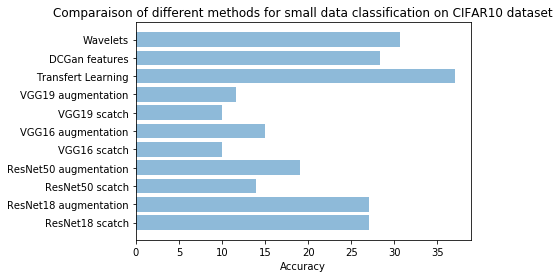

In [0]:
names = ["ResNet18 scatch", "ResNet18 augmentation", "ResNet50 scatch", "ResNet50 augmentation", "VGG16 scatch", "VGG16 augmentation", "VGG19 scatch", "VGG19 augmentation", "Transfert Learning", "DCGan features", "Wavelets"]
scores = [27, 27, 14, 19, 10, 15, 10, 11.6, 37, 28.38,30.7]

y_pos = np.arange(len(names))
 
plt.barh(y_pos, scores, align='center', alpha=0.5)
plt.yticks(y_pos, names)
plt.xlabel('Accuracy')
plt.title('Comparaison of different methods for small data classification on CIFAR10 dataset')
plt.show()